In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm.notebook import tqdm
from scipy.special import expit
import numpy as np
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from sklearn import metrics

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = (20.0, 10.0)
rcParams['legend.fontsize'] = 20
rcParams['axes.titlesize']=20
rcParams['axes.labelsize']=20
rcParams['font.size'] = 20
rcParams['lines.linewidth'] = 3

# Загрузка датасета

In [4]:
FMNIST_train = datasets.FashionMNIST('./fmnist', train=True, download=True, 
                             transform=transforms.ToTensor())

FMNIST_test = datasets.FashionMNIST('./fmnist', train=False, download=True,
                            transform=transforms.ToTensor())

In [5]:
train_big, train_small = torch.utils.data.random_split(FMNIST_train, [59000, 1000])

In [6]:
print(f'Data size:\n\t train {len(FMNIST_train)},\n\t test {len(FMNIST_test)},\n\t train big {len(train_big)},\n\t train small {len(train_small)}')

Data size:
	 train 60000,
	 test 10000,
	 train big 59000,
	 train small 1000


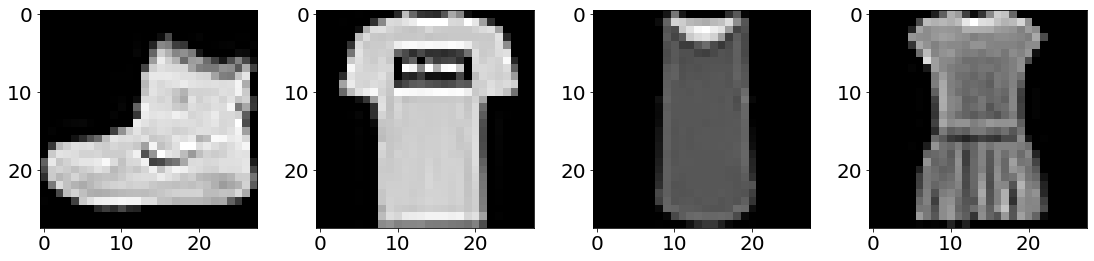

In [7]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []

for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(FMNIST_train[i][0][0]), 'gray')

plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Построение моделей ученика и учителя

In [9]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=784, num_layers=0, 
                 hidden_dim=64, output_dim=10, p=0.0):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))        
        
    def forward(self, input):
        return self.layers(input)

In [10]:
def train_teacher(train_data, test_data):
    
    teacher = Teacher
    optimizer = torch.optim.Adam(teacher.parameters())
    loss_function = torch.nn.CrossEntropyLoss()

    epochs = 5

    for i in tqdm(range(epochs)):
        train_generator = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
        teacher.train()
        for x, y in tqdm(train_generator, leave=False):
            optimizer.zero_grad()
            x = x.view([-1, 784]).to(device)
            y = y.to(device)
            predict = teacher(x)
            loss = loss_function(predict, y)
            loss.backward()
            optimizer.step()

        test_generator = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
        teacher.eval()
        for x, y in tqdm(test_generator, leave=False):
            x = x.view([-1, 784]).to(device)
            y = y.to(device)
            predict = teacher(x)
            loss = loss_function(predict, y)    

In [11]:
def distillation_train(train_data, test_data, teacher=None, T=1):   
    
    list_of_train_acc = []
    list_of_test_acc = []
    list_of_train_precision = []
    list_of_test_precision = []
    list_of_train_recall = []
    list_of_test_recall = []
    list_of_train_f1 = []
    list_of_test_f1 = []
    list_of_train_losses = []
    list_of_test_losses = []

    epochs = 5
    attempts = 3
    
    for attempt in tqdm(range(attempts)):
        student = Student
        optimizer = torch.optim.Adam(student.parameters())
        loss_function = torch.nn.CrossEntropyLoss()
        
        train_acc = []
        test_acc = []
        train_precision = []
        test_precision = []
        train_recall = []
        test_recall = []
        train_f1 = []
        test_f1 = []
        train_loss = []
        test_loss = []
        
        for epoch in tqdm(range(epochs), leave=False):
            train_generator = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
            it = 0
            for x, y in tqdm(train_generator, leave=False):
                it += 1
                optimizer.zero_grad()
                x = x.view([-1, 784]).to(device)
                y = y.to(device)
                student_output = student(x)
                
                if (teacher == None):
                    loss = loss_function(student_output, y)
                else:
                    teacher_output = teacher(x)
                    loss = loss_function(student_output, y)\
                    - (torch.softmax(teacher_output/T, axis=1) * torch.log(torch.softmax(student_output/T, axis=1))).mean()

                loss.backward()
                optimizer.step()
                if (it == 60):
                    train_acc.append(metrics.accuracy_score(y, torch.argmax(student_output, axis=1)))
                    train_precision.append(metrics.precision_score(y, torch.argmax(student_output, axis=1), average='weighted'))
                    train_recall.append(metrics.recall_score(y, torch.argmax(student_output, axis=1), average='weighted'))
                    train_f1.append(metrics.f1_score(y, torch.argmax(student_output, axis=1), average='weighted'))
                    train_loss.append(loss.item())
                    it = 0
                
            test_generator = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)
            it = 0
            for x, y in tqdm(test_generator, leave=False):
                it += 1
                x = x.view([-1, 784]).to(device)
                y = y.to(device)
                output = student(x)
                
                loss = loss_function(output, y)
                    
                if (it == 10):
                    test_acc.append(metrics.accuracy_score(y, torch.argmax(output, axis=1)))
                    test_precision.append(metrics.precision_score(y, torch.argmax(output, axis=1), average='weighted'))
                    test_recall.append(metrics.recall_score(y, torch.argmax(output, axis=1), average='weighted'))
                    test_f1.append(metrics.f1_score(y, torch.argmax(output, axis=1), average='weighted'))
                    test_loss.append(loss.item())
                    it = 0
        
        list_of_train_acc.append(train_acc)
        list_of_train_precision.append(train_precision)
        list_of_train_recall.append(train_recall)
        list_of_train_f1.append(train_f1)
        list_of_test_acc.append(test_acc)
        list_of_test_precision.append(test_precision)
        list_of_test_recall.append(test_recall)
        list_of_test_f1.append(test_f1)
        list_of_train_losses.append(train_loss)
        list_of_test_losses.append(test_loss)
        
    return list_of_train_acc, list_of_train_precision, list_of_train_recall, list_of_train_f1,\
            list_of_test_acc, list_of_test_precision, list_of_test_recall, list_of_test_f1,\
            list_of_train_losses, list_of_test_losses

# Обучение модели ученика без учителя

In [14]:
Student0 = Perceptron(num_layers=1)

In [15]:
_ = Student0.train()
list_of_train_acc, list_of_train_precision, list_of_train_recall, list_of_train_f1,\
list_of_test_acc, list_of_test_precision, list_of_test_recall, list_of_test_f1,\
list_of_train_losses, list_of_test_losses = distillation_train(FMNIST_train, FMNIST_test)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

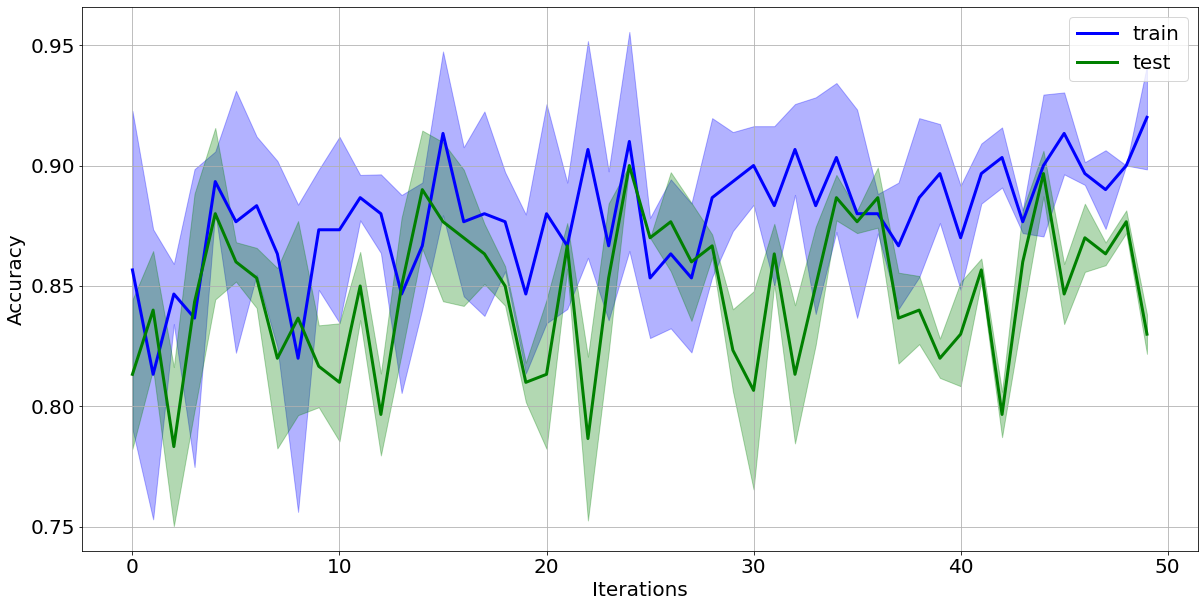

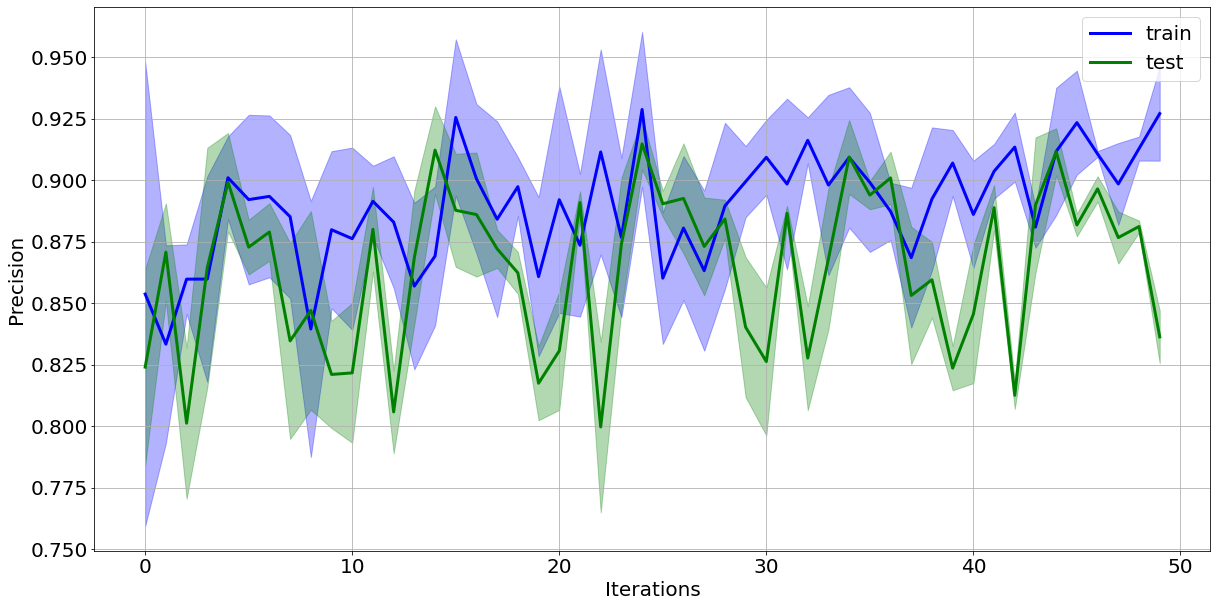

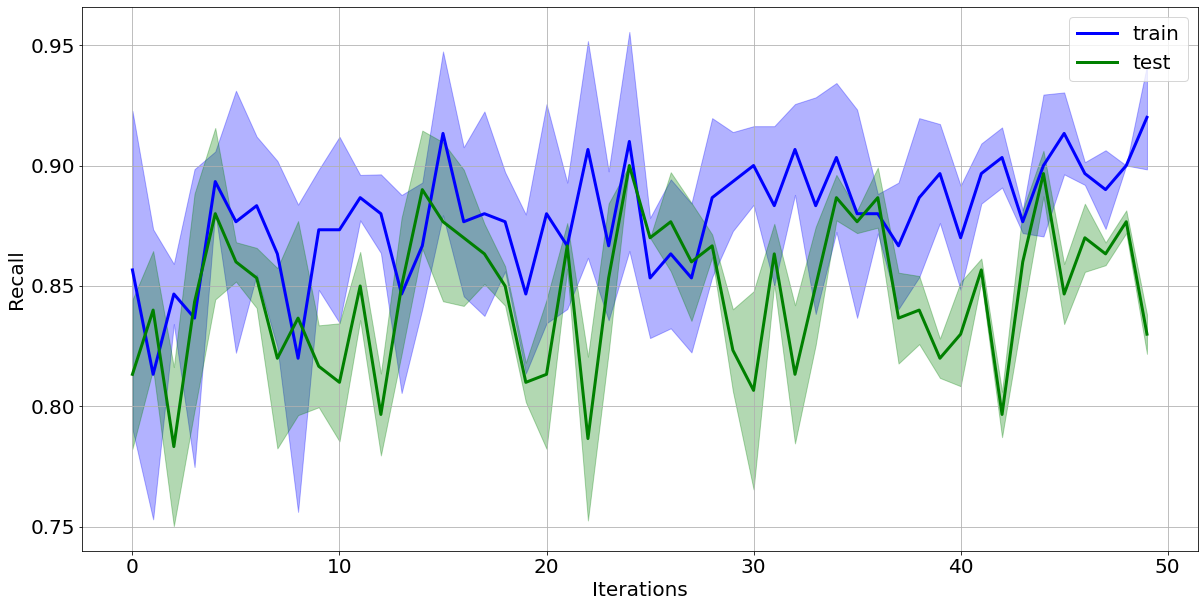

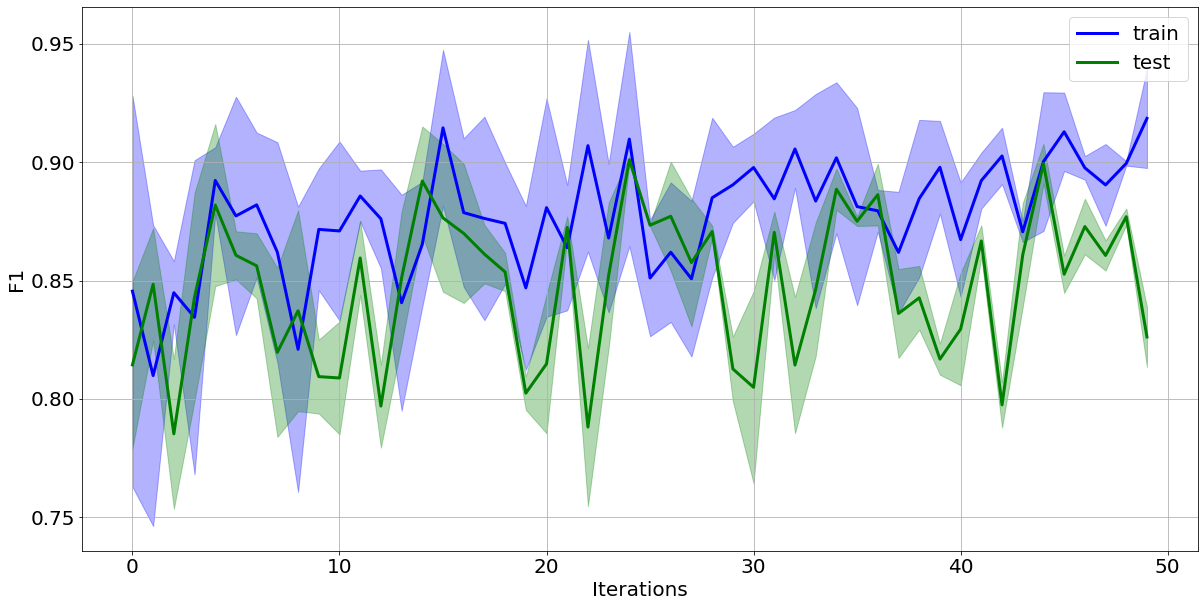

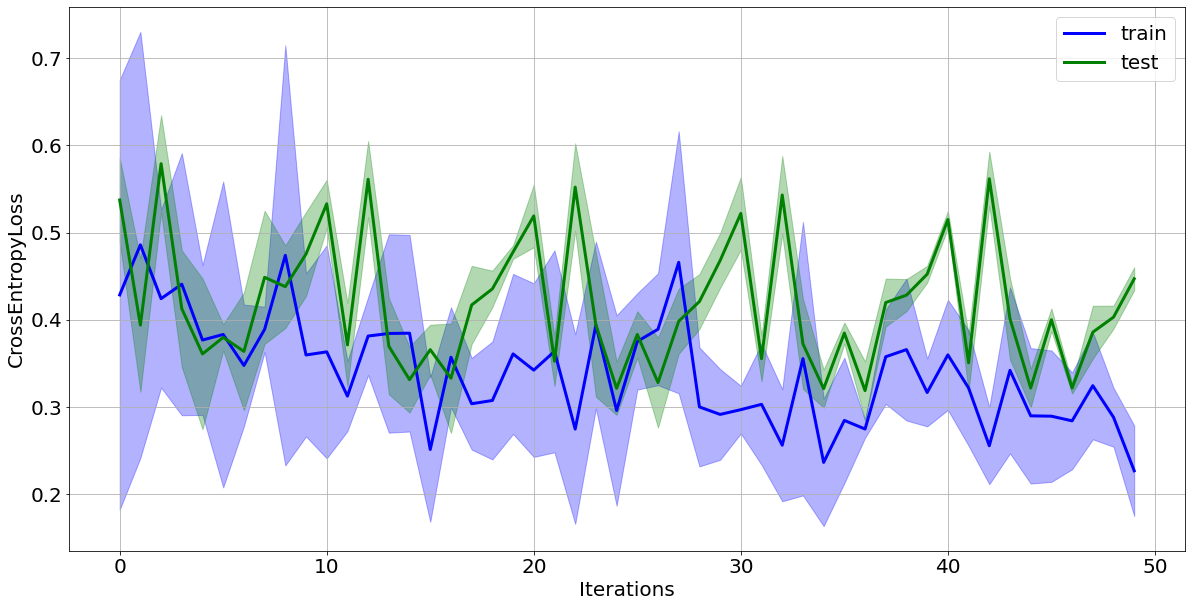

In [16]:
for train_metric, test_metric, label in zip([list_of_train_acc, list_of_train_precision, list_of_train_recall,\
                                            list_of_train_f1, list_of_train_losses],\
                                            [list_of_test_acc, list_of_test_precision, list_of_test_recall,
                                            list_of_test_f1, list_of_test_losses],\
                                            ['Accuracy', 'Precision', 'Recall', 'F1', 'CrossEntropyLoss']):
    mean = np.array(train_metric).mean(0)
    std = np.array(train_metric).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='blue', label='train')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='blue')
    
    mean = np.array(test_metric).mean(0)
    std = np.array(test_metric).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='green', label='test')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='green')
    
    plt.xlabel('Iterations')
    plt.ylabel(label)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

# Обучение модели ученика с учителем

In [18]:
Student1 = Perceptron(num_layers=1)
Teacher1 = Perceptron(num_layers=4)

In [19]:
_ = Teacher1.train()
train_teacher(FMNIST_train, FMNIST_test)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [20]:
_ = Student1.train()
list_of_train_acc_dist, list_of_train_precision_dist, list_of_train_recall_dist, list_of_train_f1_dist,\
list_of_test_acc_dist, list_of_test_precision_dist, list_of_test_recall_dist, list_of_test_f1_dist,\
list_of_train_losses_dist, list_of_test_losses_dist = distillation_train(FMNIST_train, FMNIST_test, teacher=Teacher1)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

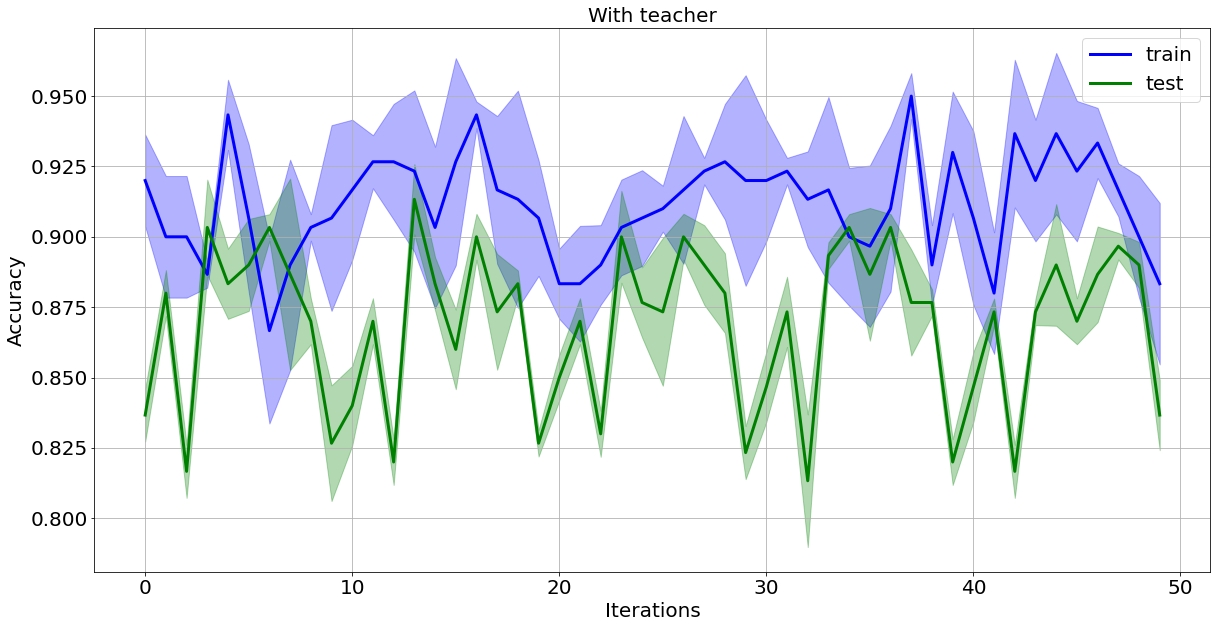

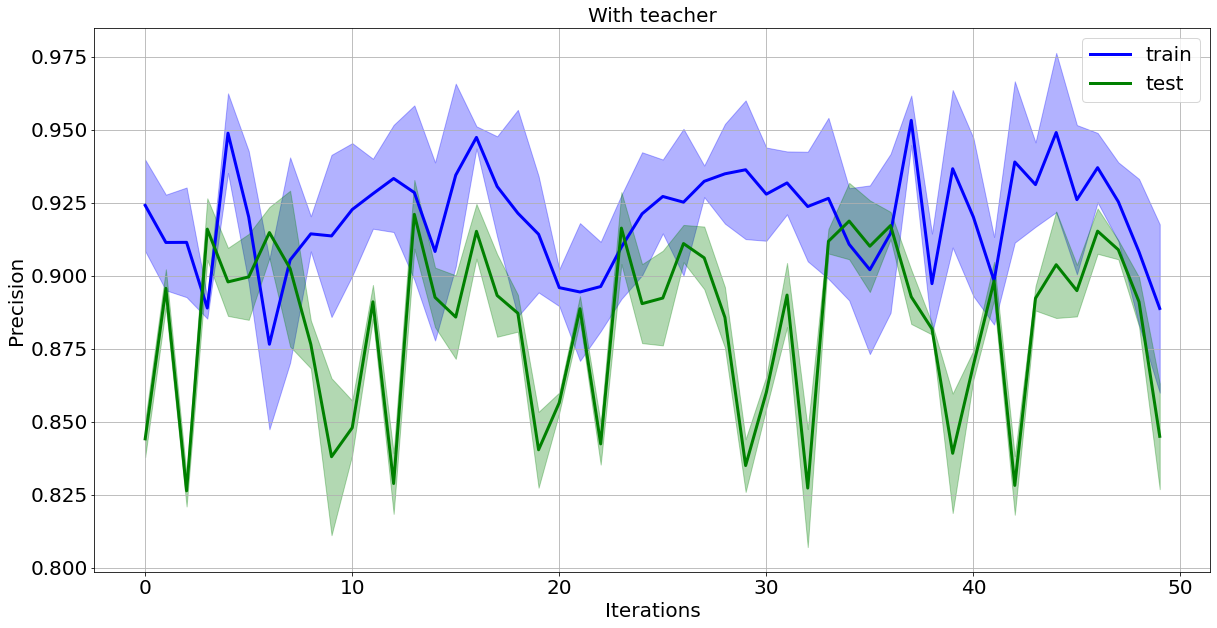

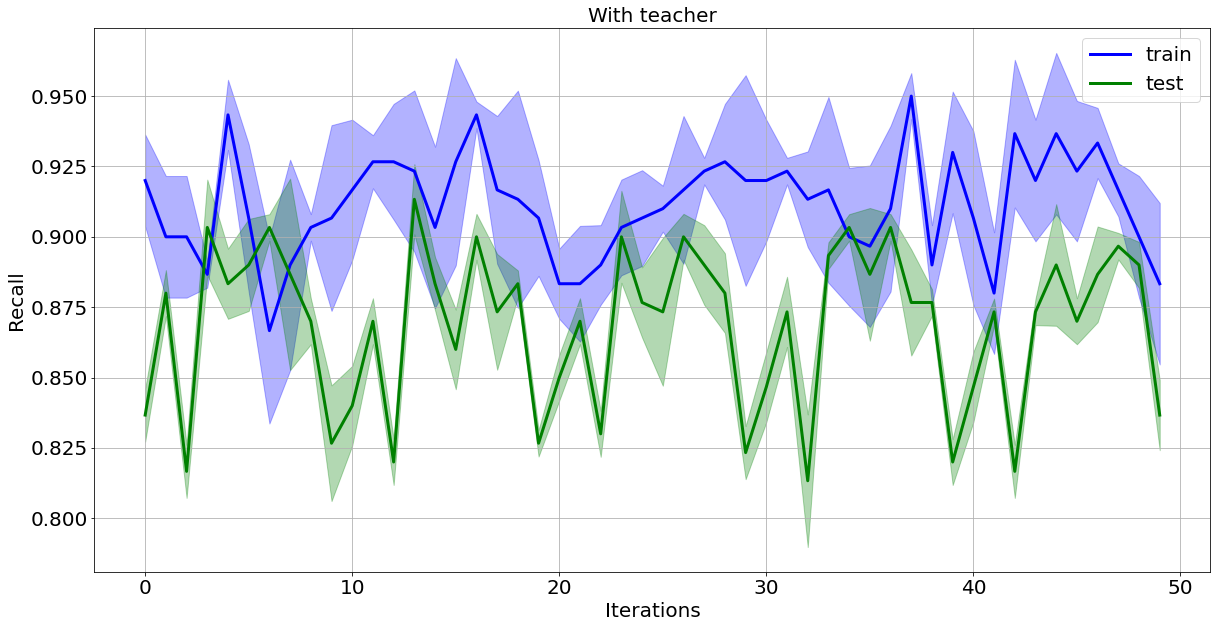

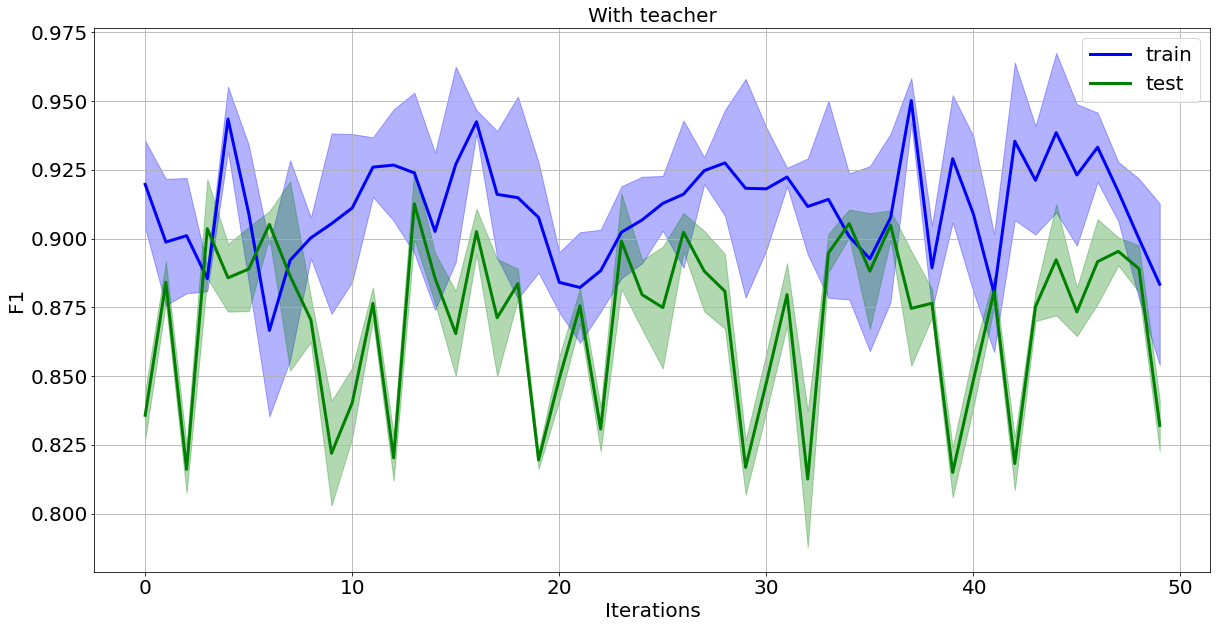

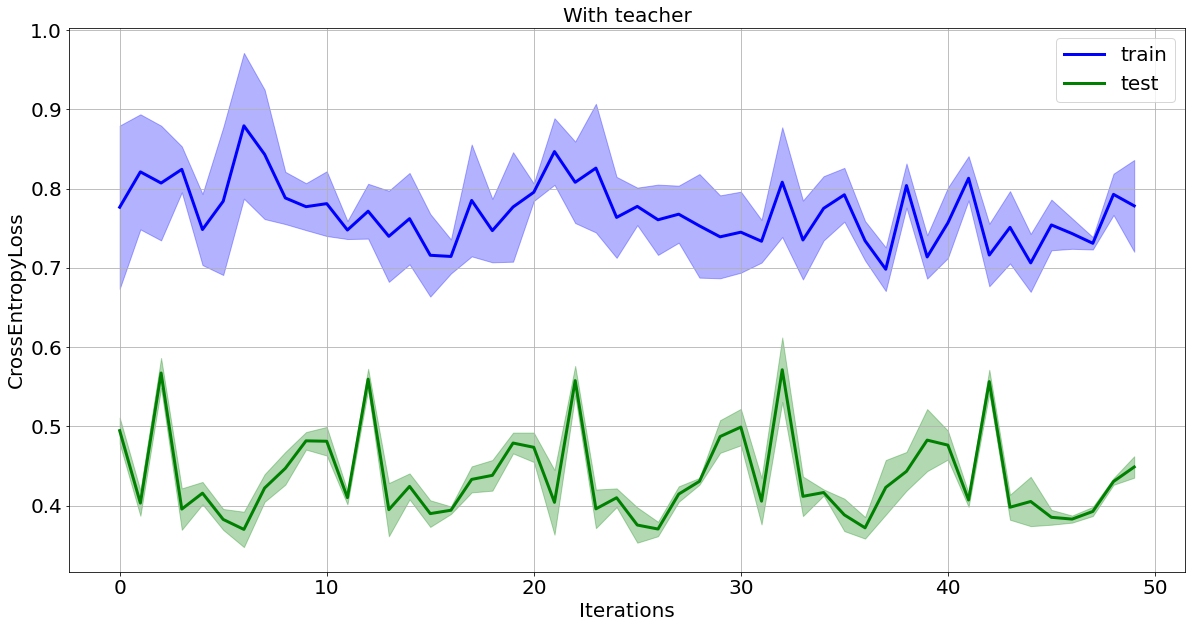

In [21]:
for train_metric, test_metric, label in zip([list_of_train_acc_dist, list_of_train_precision_dist, list_of_train_recall_dist,\
                                            list_of_train_f1_dist, list_of_train_losses_dist],\
                                            [list_of_test_acc_dist, list_of_test_precision_dist, list_of_test_recall_dist,
                                            list_of_test_f1_dist, list_of_test_losses_dist],\
                                            ['Accuracy', 'Precision', 'Recall', 'F1', 'CrossEntropyLoss']):
    mean = np.array(train_metric).mean(0)
    std = np.array(train_metric).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='blue', label='train')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='blue')
    
    mean = np.array(test_metric).mean(0)
    std = np.array(test_metric).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='green', label='test')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='green')
    
    plt.title('With teacher')
    plt.xlabel('Iterations')
    plt.ylabel(label)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

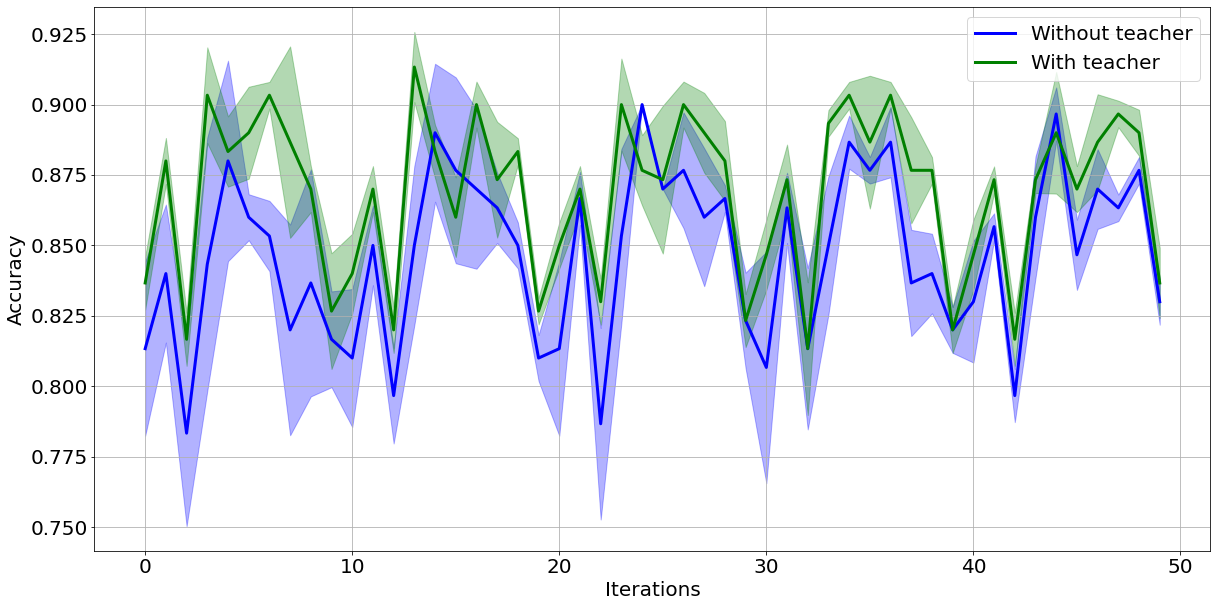

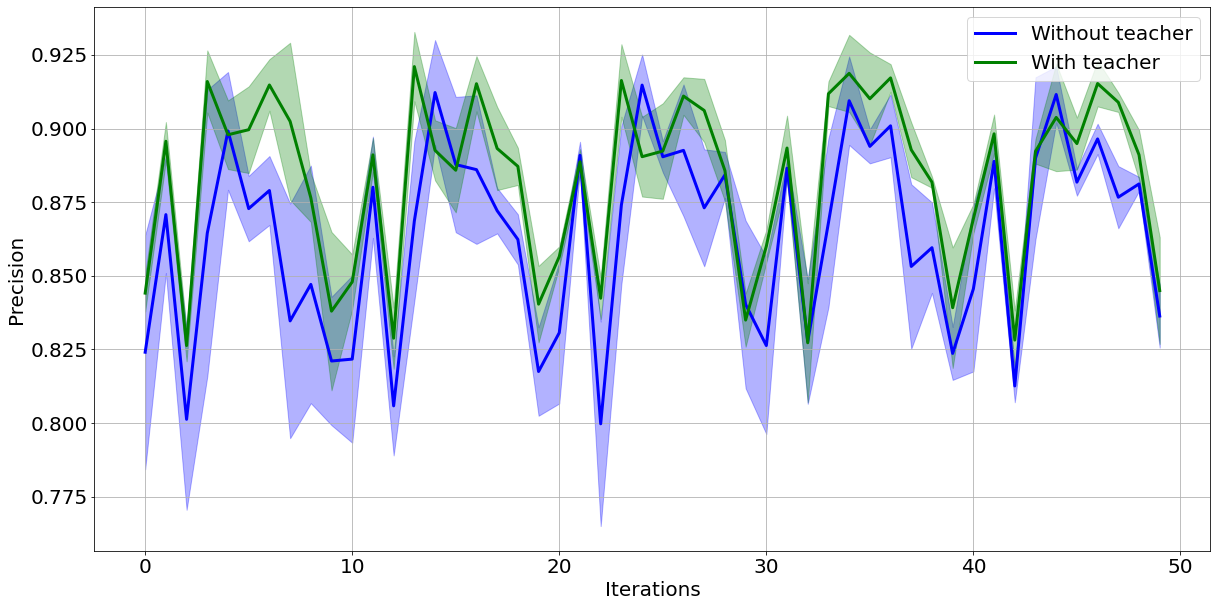

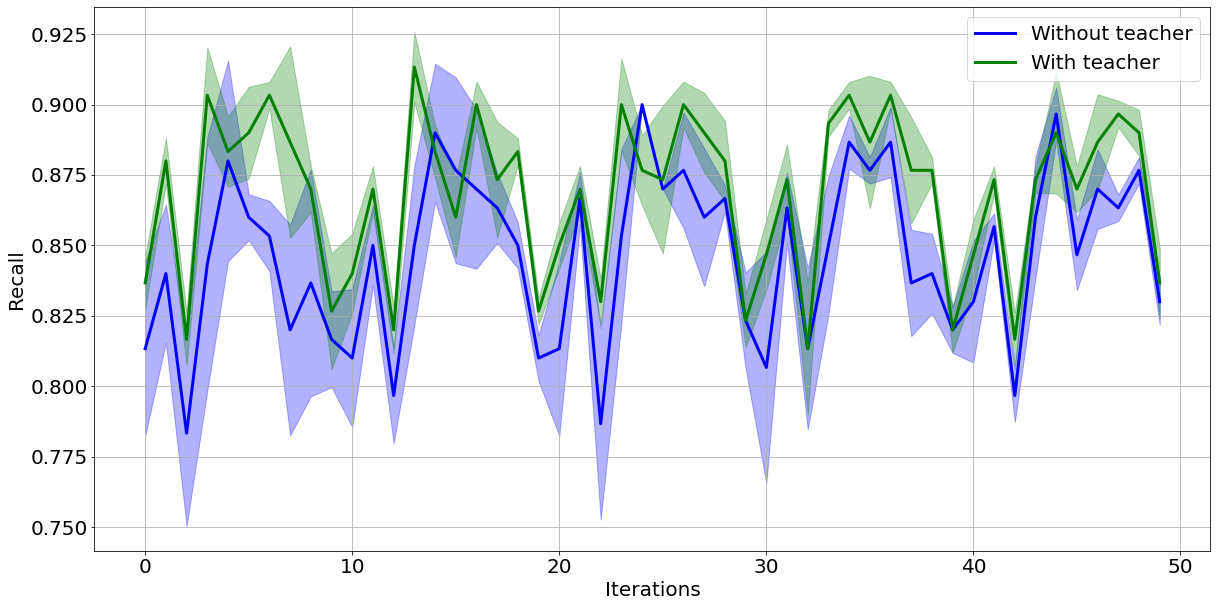

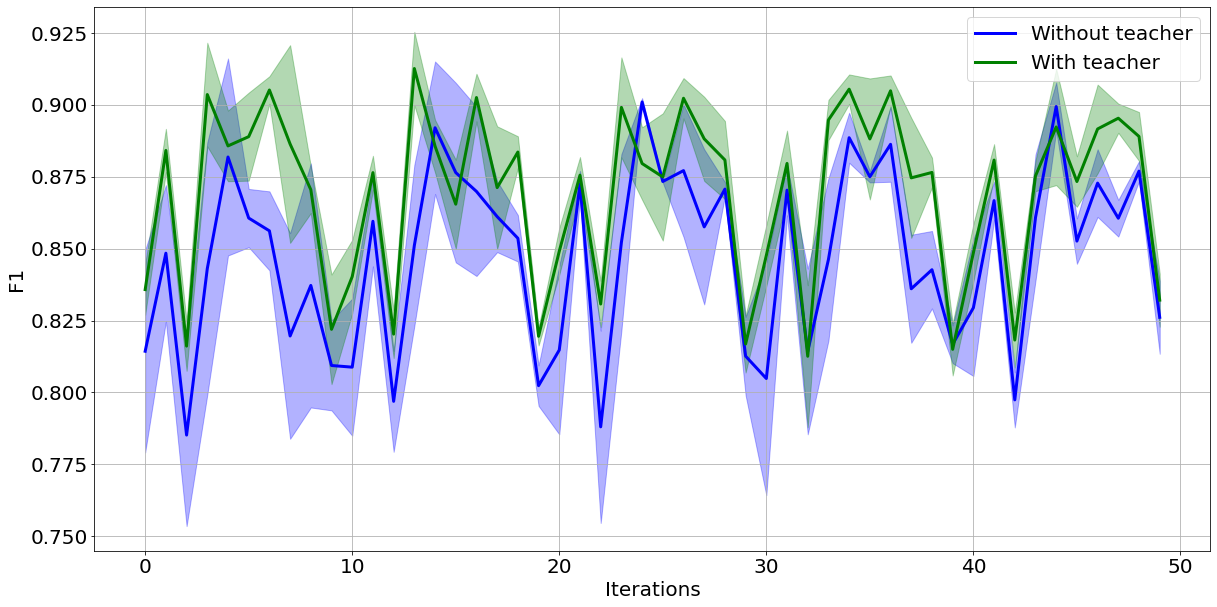

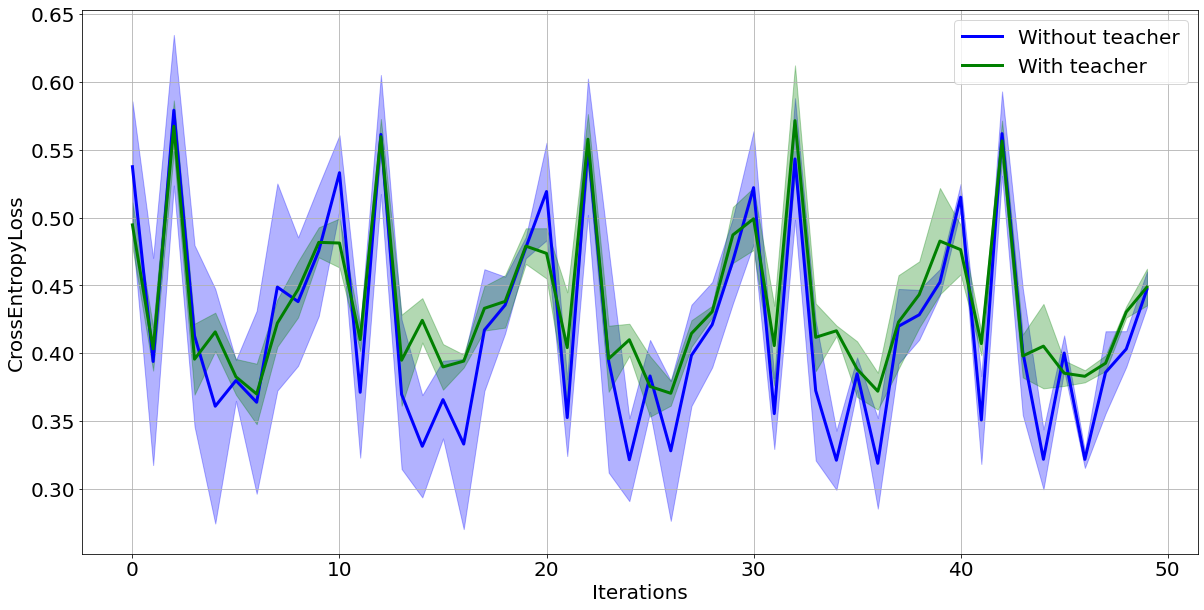

In [22]:
for test_metric, test_metric_dist, label in zip([list_of_test_acc, list_of_test_precision, list_of_test_recall,
                                                list_of_test_f1, list_of_test_losses],
                                                [list_of_test_acc_dist, list_of_test_precision_dist, list_of_test_recall_dist,
                                                list_of_test_f1_dist, list_of_test_losses_dist],
                                                ['Accuracy', 'Precision', 'Recall', 'F1', 'CrossEntropyLoss']):
    mean = np.array(test_metric).mean(0)
    std = np.array(test_metric).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='blue', label='Without teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='blue')
    
    mean = np.array(test_metric_dist).mean(0)
    std = np.array(test_metric_dist).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='green', label='With teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='green')
    
    plt.xlabel('Iterations')
    plt.ylabel(label)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

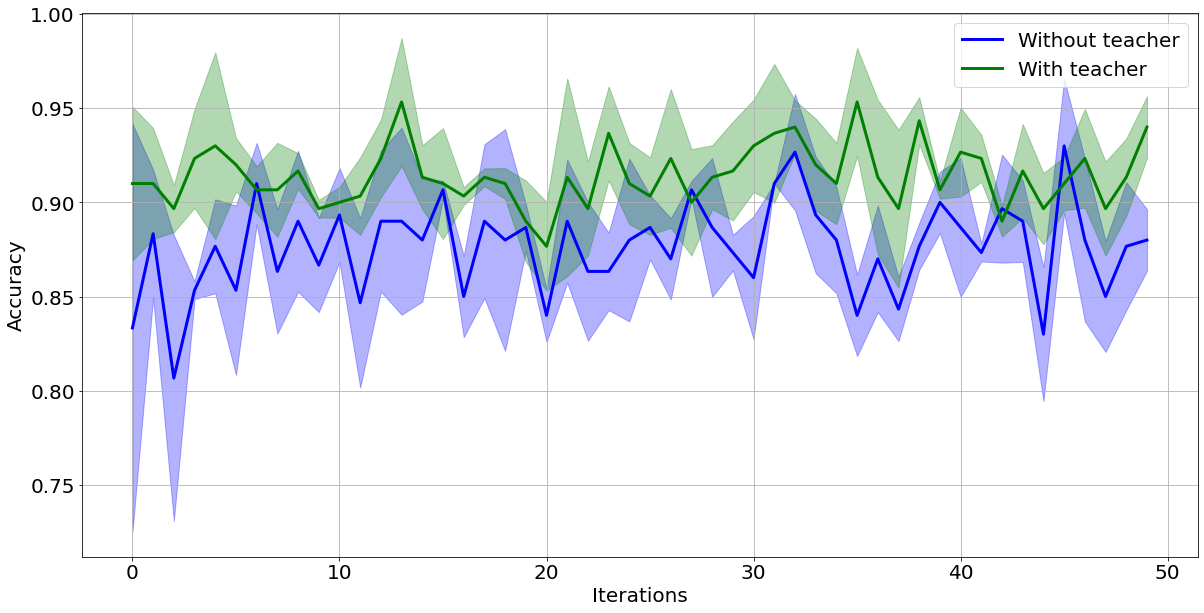

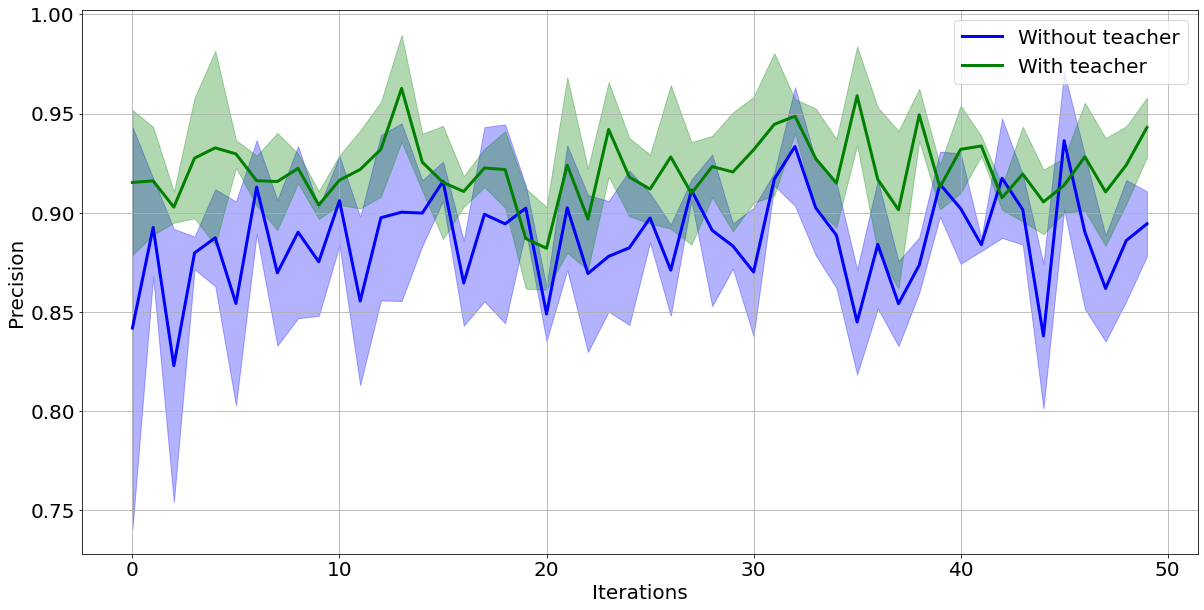

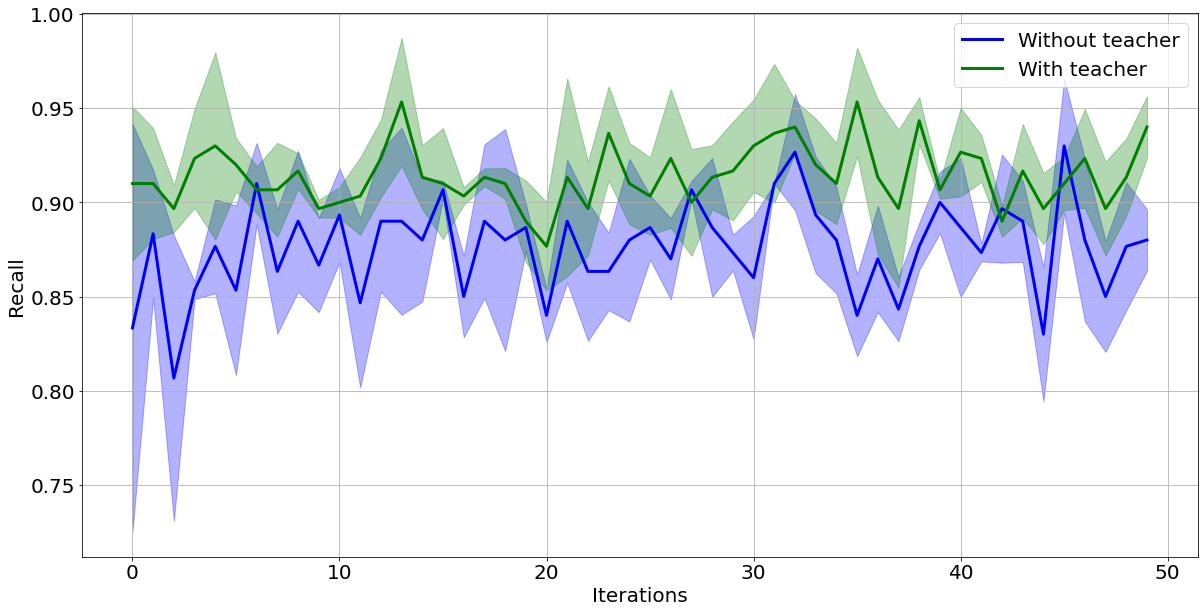

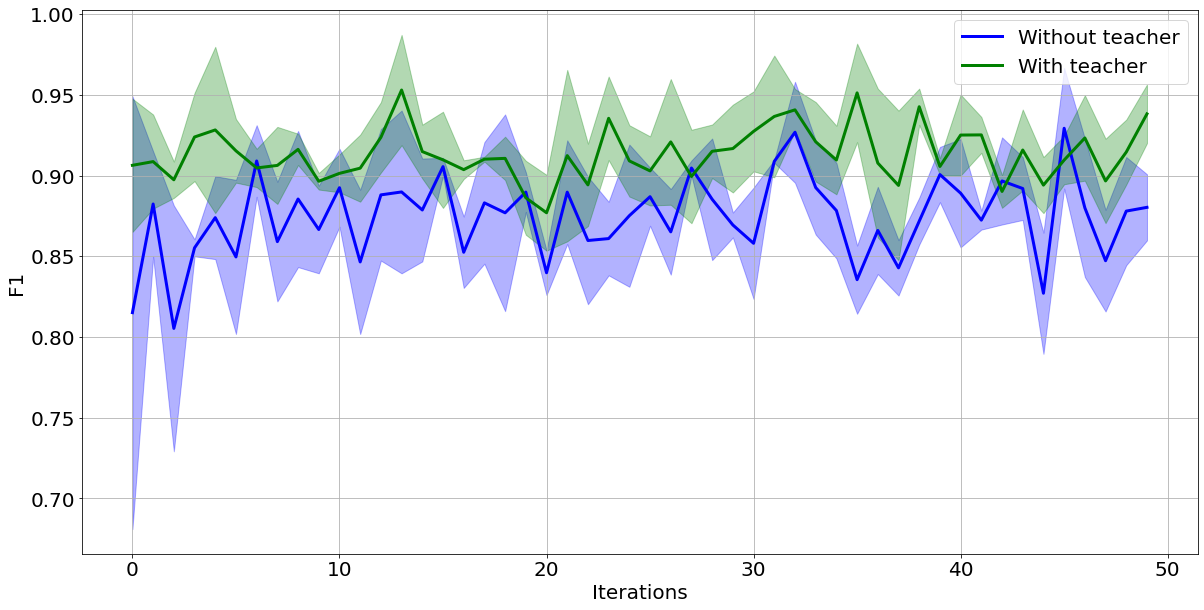

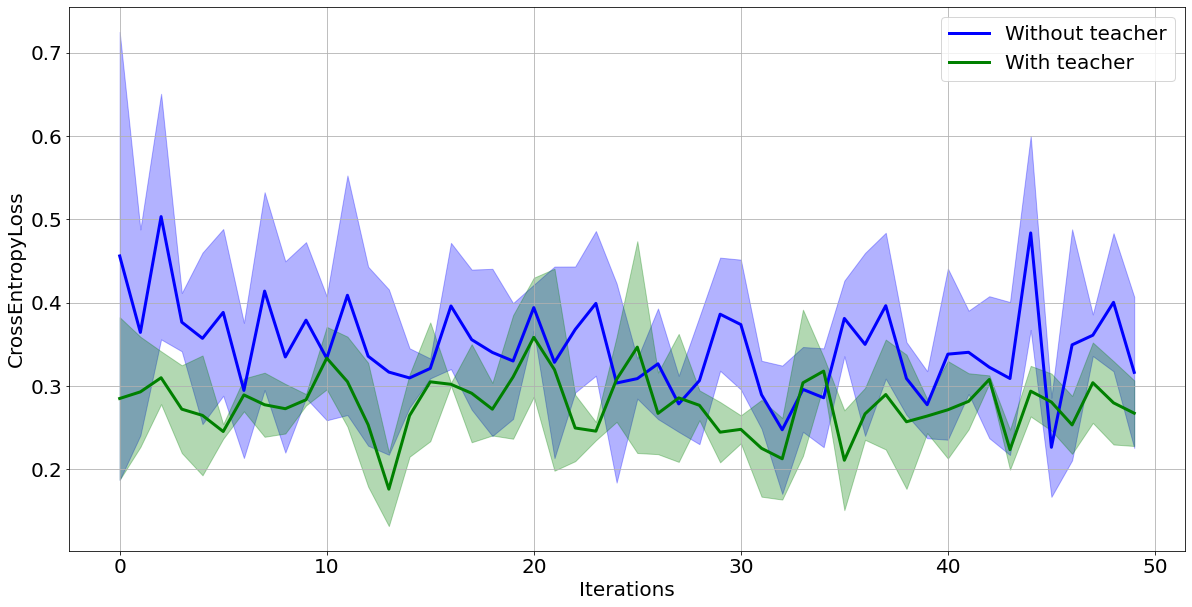

In [22]:
for train_metric, train_metric_dist, label in zip([list_of_train_acc, list_of_train_precision, list_of_train_recall,
                                                list_of_train_f1, list_of_train_losses],
                                                [list_of_train_acc_dist, list_of_train_precision_dist, list_of_train_recall_dist,
                                                list_of_train_f1_dist, list_of_train_losses_dist],
                                                ['Accuracy', 'Precision', 'Recall', 'F1', 'CrossEntropyLoss']):
    mean = np.array(train_metric).mean(0)
    std = np.array(train_metric).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='blue', label='Without teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='blue')
    
    mean = np.array(train_metric_dist).mean(0)
    std = np.array(train_metric_dist).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='green', label='With teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='green')
    
    plt.xlabel('Iterations')
    plt.ylabel(label)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

# на малоресурсном домене

In [29]:
Student = Perceptron(num_layers=1)
Teacher = Perceptron(num_layers=4)

In [30]:
_ = Teacher.train()
train_teacher(train_big, FMNIST_test)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/922 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/922 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/922 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/922 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/922 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [31]:
_ = Student.train()
list_of_train_acc, list_of_train_precision, list_of_train_recall, list_of_train_f1,\
list_of_test_acc, list_of_test_precision, list_of_test_recall, list_of_test_f1,\
list_of_train_losses, list_of_test_losses = distillation_train(train_small, FMNIST_test)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
Student = Perceptron(num_layers=1)

In [34]:
_ = Student.train()
list_of_train_acc_dist, list_of_train_precision_dist, list_of_train_recall_dist, list_of_train_f1_dist,\
list_of_test_acc_dist, list_of_test_precision_dist, list_of_test_recall_dist, list_of_test_f1_dist,\
list_of_train_losses_dist, list_of_test_losses_dist = distillation_train(train_small, FMNIST_test, teacher=Teacher)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

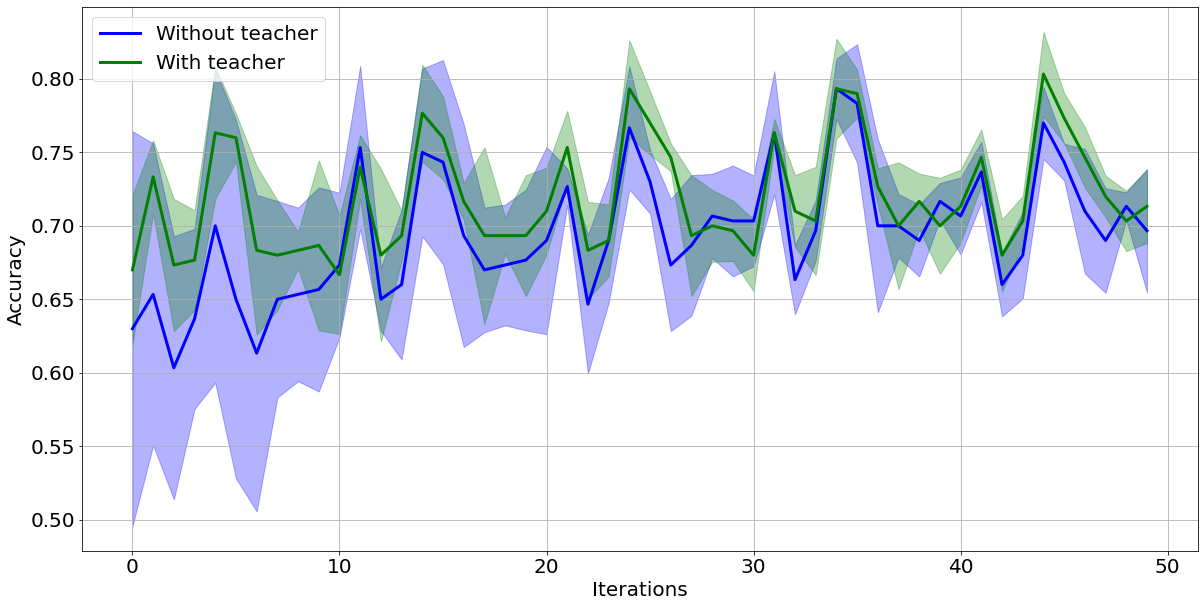

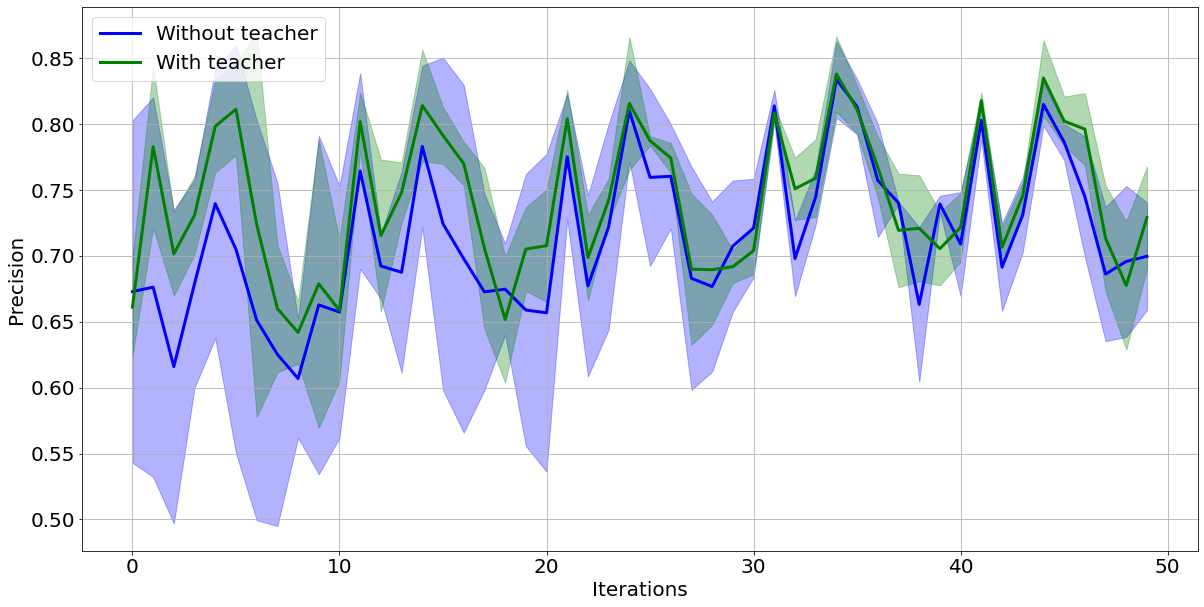

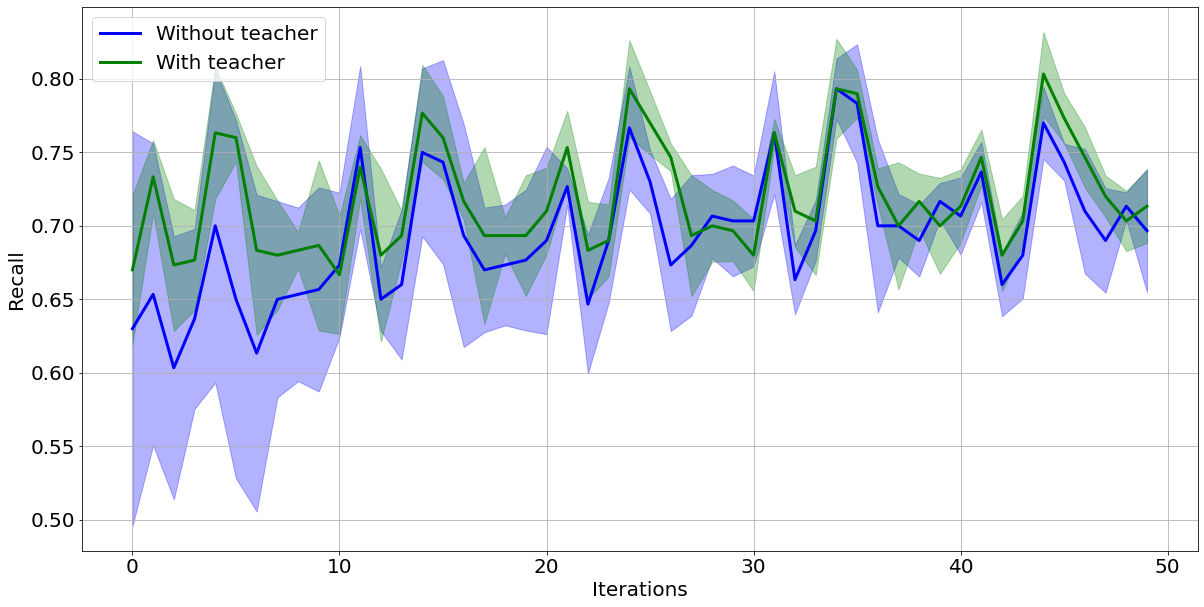

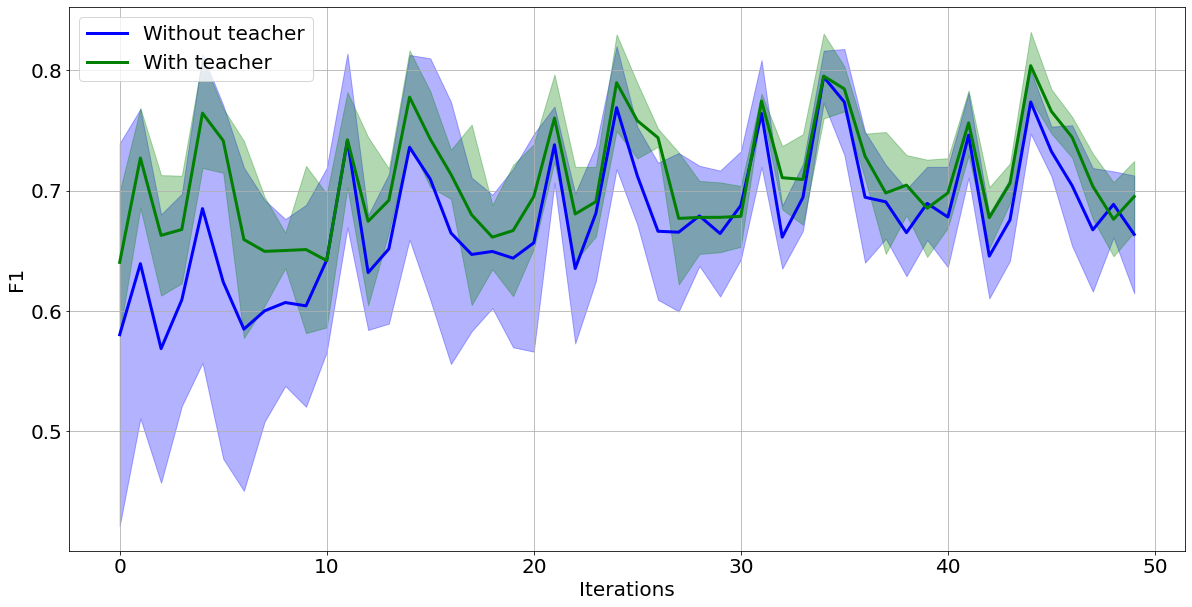

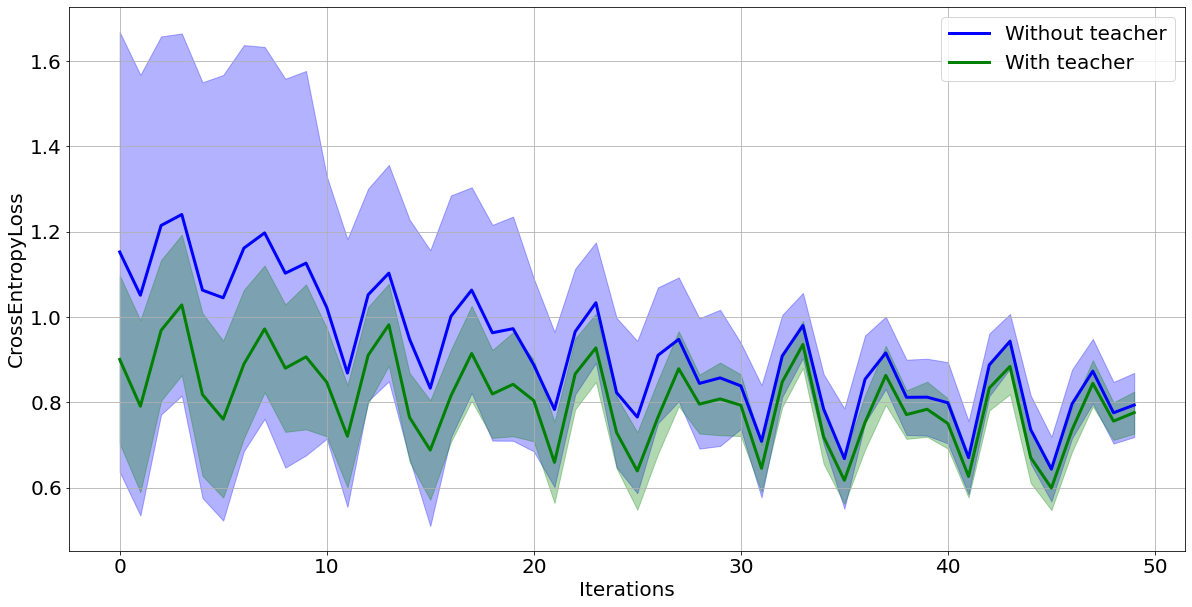

In [35]:
for test_metric, test_metric_dist, label in zip([list_of_test_acc, list_of_test_precision, list_of_test_recall,
                                                list_of_test_f1, list_of_test_losses],
                                                [list_of_test_acc_dist, list_of_test_precision_dist, list_of_test_recall_dist,
                                                list_of_test_f1_dist, list_of_test_losses_dist],
                                                ['Accuracy', 'Precision', 'Recall', 'F1', 'CrossEntropyLoss']):
    mean = np.array(test_metric).mean(0)
    std = np.array(test_metric).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='blue', label='Without teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='blue')
    
    mean = np.array(test_metric_dist).mean(0)
    std = np.array(test_metric_dist).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='green', label='With teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='green')
    
    plt.xlabel('Iterations')
    plt.ylabel(label)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

# Выборка с шумом

In [36]:
image = FMNIST_train[0][0][0]

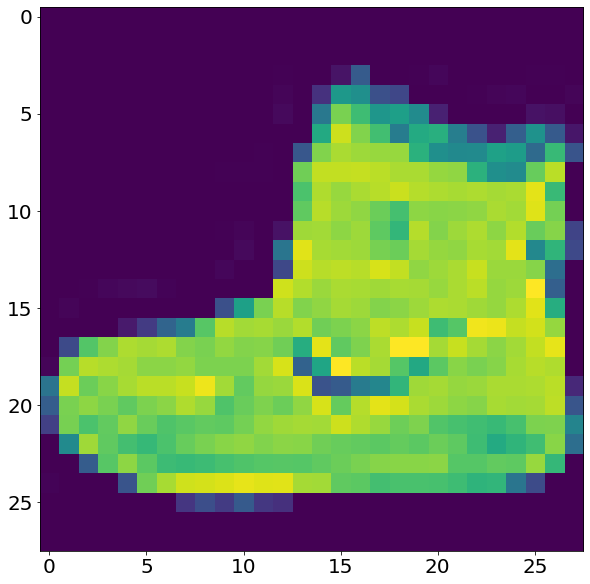

In [37]:
plt.imshow(image)

In [38]:
image = image + 0.1*torch.randn(*image.shape)

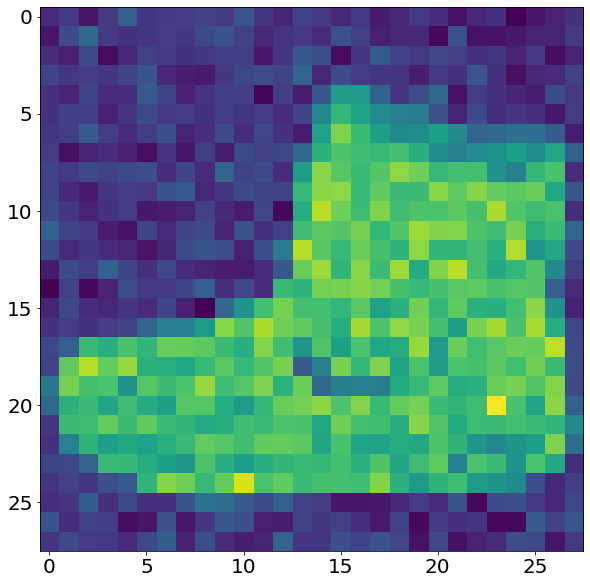

In [39]:
plt.imshow(image)

In [40]:
def train_teacher_with_noise(train_data, test_data):
    
    teacher = Teacher
    optimizer = torch.optim.Adam(teacher.parameters())
    loss_function = torch.nn.CrossEntropyLoss()

    epochs = 5
    noise_factor=0.1
    
    for epoch in tqdm(range(epochs)):
        train_generator = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
        teacher.train()
        for x, y in tqdm(train_generator, leave=False):
            noise_image = x + noise_factor*torch.randn(*x.shape)
            noise_image = np.clip(noise_image, 0., 1.)
            optimizer.zero_grad()
            noise_image = noise_image.view([-1, 784]).to(device)
            y = y.to(device)
            predict = teacher(noise_image)
            loss = loss_function(predict, y)
            loss.backward()
            optimizer.step()

        test_generator = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
        teacher.eval()
        for x, y in tqdm(test_generator, leave=False):
            x = x.view([-1, 784]).to(device)
            y = y.to(device)
            predict = teacher(x)
            loss = loss_function(predict, y) 

In [41]:
Student = Perceptron(num_layers=1)
Teacher = Perceptron(num_layers=4)

In [42]:
_ = Teacher.train()
train_teacher_with_noise(train_big, FMNIST_test)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/922 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/922 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/922 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/922 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/922 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [43]:
_ = Student.train()
list_of_train_acc_dist, list_of_train_precision_dist, list_of_train_recall_dist, list_of_train_f1_dist,\
list_of_test_acc_dist, list_of_test_precision_dist, list_of_test_recall_dist, list_of_test_f1_dist,\
list_of_train_losses_dist, list_of_test_losses_dist = distillation_train(train_small, FMNIST_test, teacher=Teacher)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

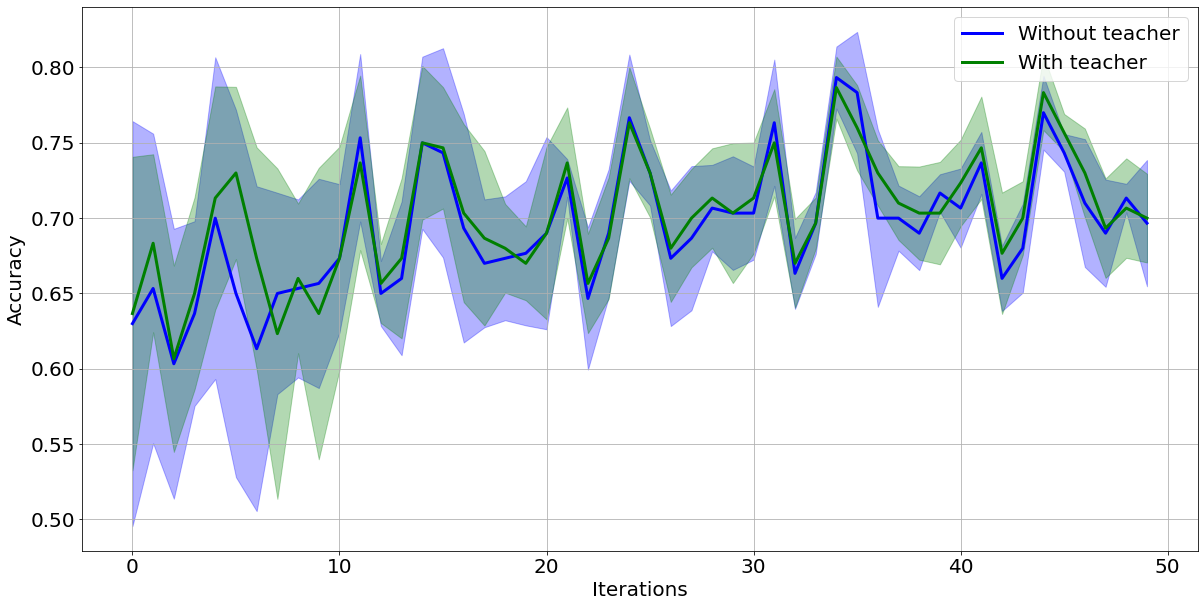

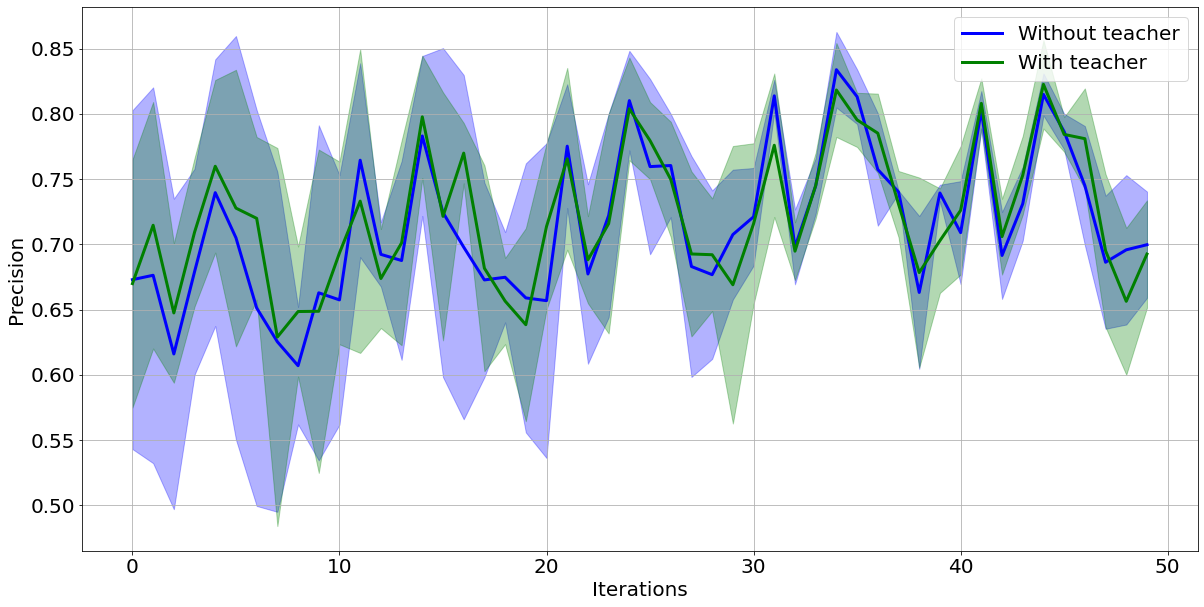

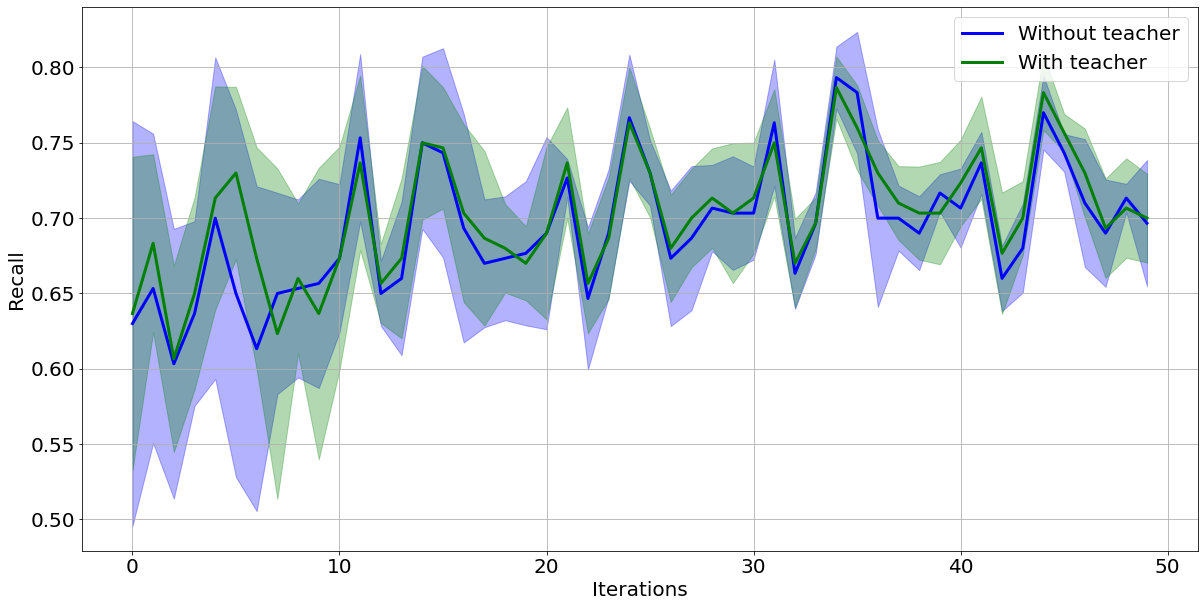

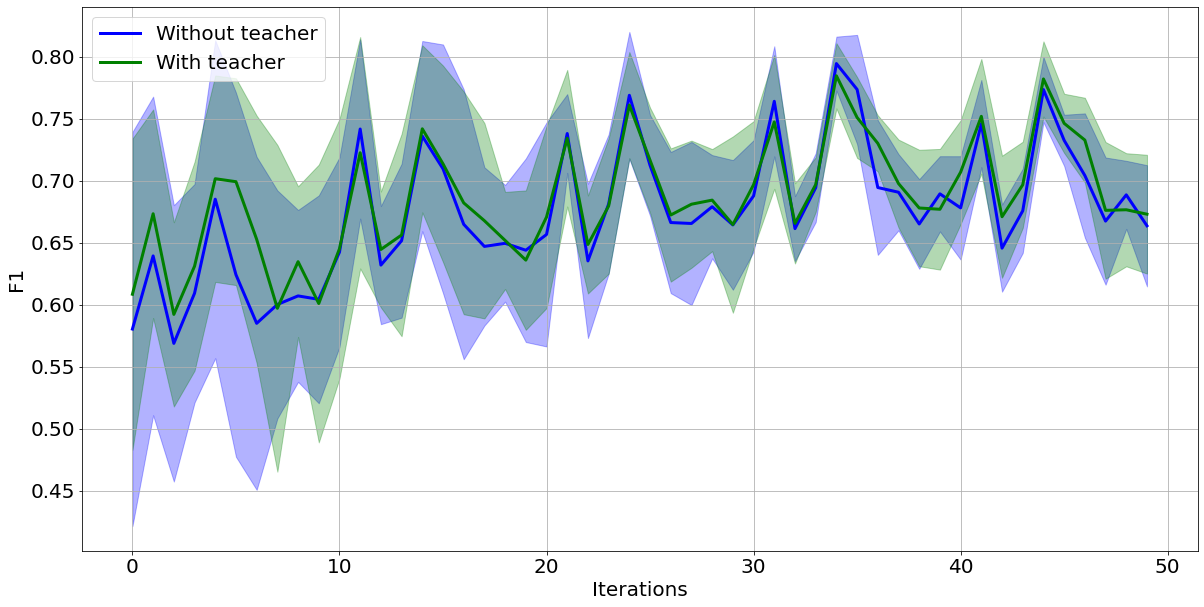

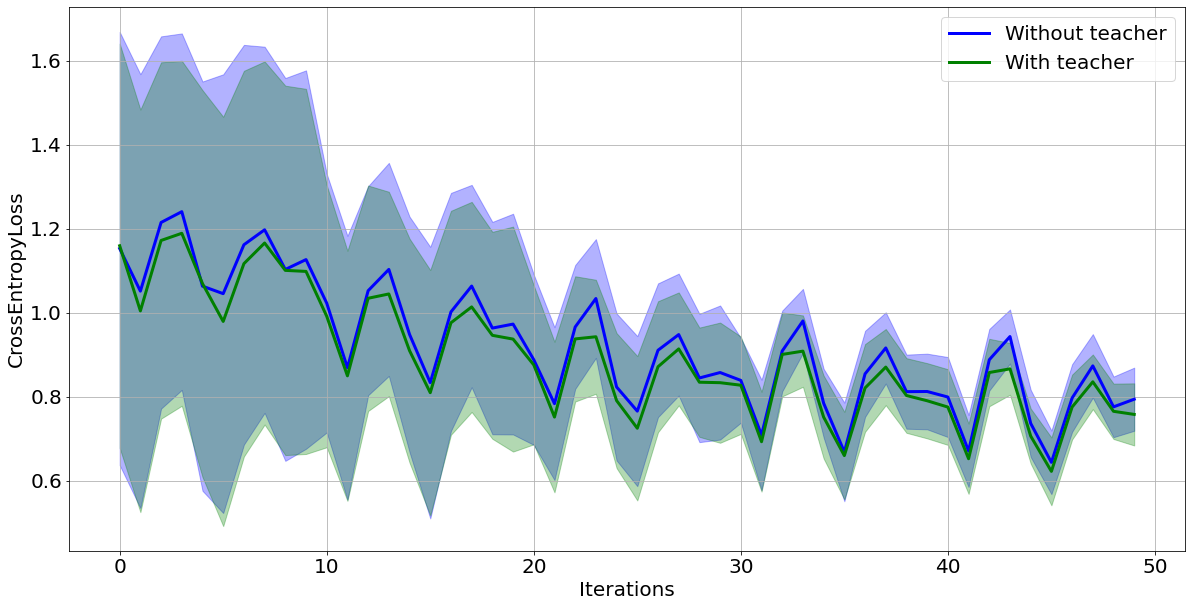

In [44]:
for test_metric, test_metric_dist, label in zip([list_of_test_acc, list_of_test_precision, list_of_test_recall,
                                                list_of_test_f1, list_of_test_losses],
                                                [list_of_test_acc_dist, list_of_test_precision_dist, list_of_test_recall_dist,
                                                list_of_test_f1_dist, list_of_test_losses_dist],
                                                ['Accuracy', 'Precision', 'Recall', 'F1', 'CrossEntropyLoss']):
    mean = np.array(test_metric).mean(0)
    std = np.array(test_metric).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='blue', label='Without teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='blue')
    
    mean = np.array(test_metric_dist).mean(0)
    std = np.array(test_metric_dist).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='green', label='With teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='green')
    
    plt.xlabel('Iterations')
    plt.ylabel(label)
    plt.grid()
    plt.legend(loc='best')
    plt.show()